<h1>Daten und Programmbibliotheken laden</h1>

In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.options.display.float_format = '{:.2f}'.format


dateipfad_FULL_DATA = "C:\\Users\\AMeinert\\Documents\\Python_Scripts\\projects\\MA\\data\\share\\"
datei_FULL_DATA = "data_full.csv"

df_full_data = pd.read_csv(dateipfad_FULL_DATA + datei_FULL_DATA, sep=";", encoding="ISO-8859-1")

#df_full_data.dtypes
#df_full_data.columns[243]

C:\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (242,243) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [2]:
def plot_hist_and_dist(df, clist, title_addition=""):
    
    df_trans = df[clist].apply(pd.to_numeric)
    
    i = len(clist)

    for col in clist:

        values_boxplot = df_trans[~df_trans[col].isnull()][col]
        values_dist = values_boxplot.sort_values(ascending=True).reset_index().drop(["index"], axis = 1)  
        
        fig = plt.figure(figsize=(5,12))

        plt.suptitle("Histogramm und Verteilung für " + col + " " + title_addition, fontsize=16)
        
        ax1 = plt.subplot(i, 2, 1)

        ax1.boxplot(values_boxplot, showmeans=True)
        ax1.set_title('raw HIST')

        ax2 = plt.subplot(i, 2, 2)

        ax2.boxplot(np.log2(values_boxplot+1), showmeans=True)
        ax2.set_title('log HIST')

        ax3 = plt.subplot(i, 2, 3)

        ax3.plot(values_dist)
        ax3.set_title('raw DIST')

        ax4 = plt.subplot(i, 2, 4)

        ax4.plot(np.log2(values_dist+1))
        ax4.set_title('log DIST')
        
        #plt.subplots_adjust(left=None, bottom=None, right=None, top=0.9, wspace=None, hspace=None)


<h1>Histogramm und Verteilung Matrixplot </h1>

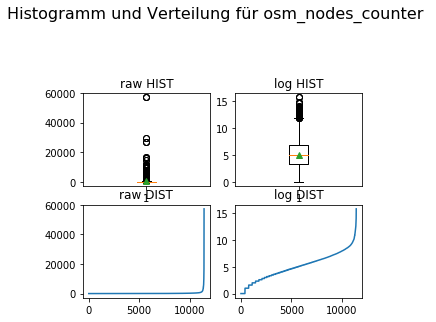

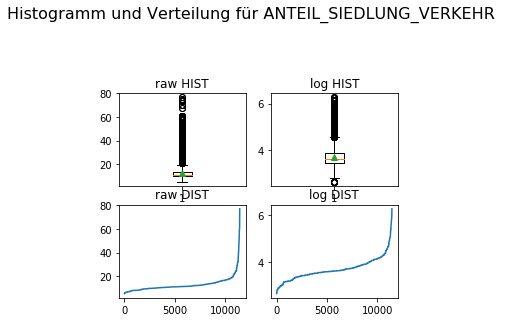

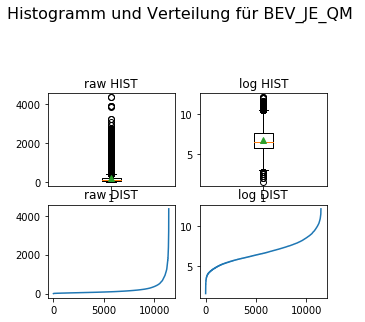

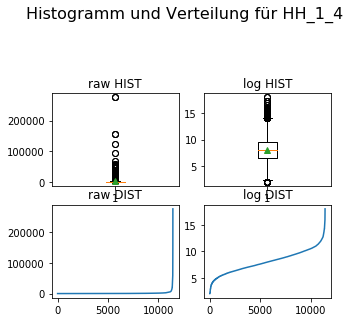

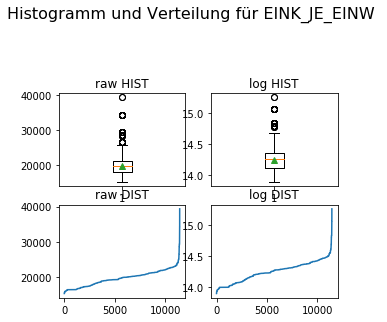

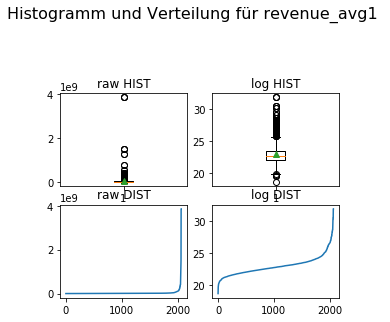

In [4]:
collist = ["osm_nodes_counter", "ANTEIL_SIEDLUNG_VERKEHR", "BEV_JE_QM", "HH_1_4", "EINK_JE_EINW", "revenue_avg1"]

df_full_data[collist].apply(pd.to_numeric).describe().transpose()

plot_hist_and_dist(df_full_data, collist)


<h1>Histogramm und Verteilung Matrixplot (Outlier entfernen)</h1>

C:\Anaconda3\lib\site-packages\pandas\core\frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


'Vorhandene Branches im Subset: 542.0/ Regionen mit Branches: 516'

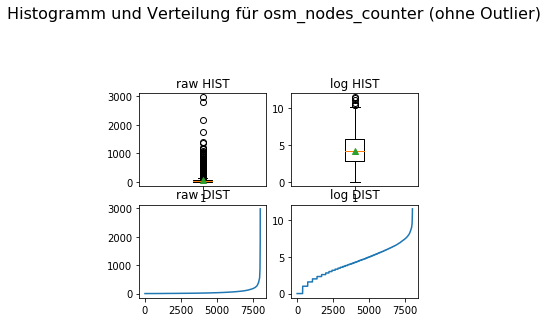

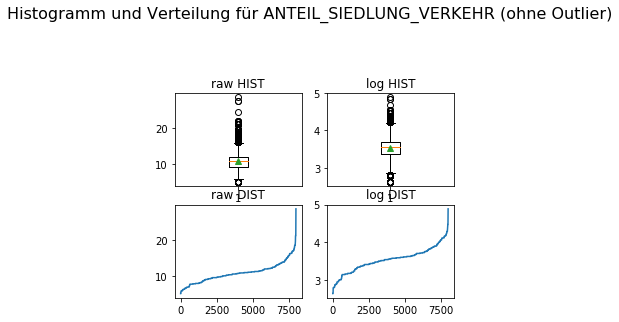

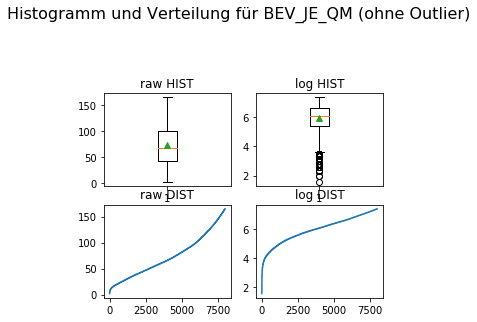

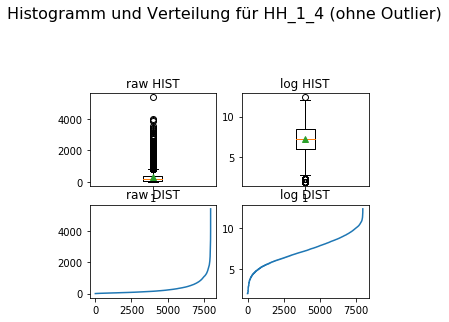

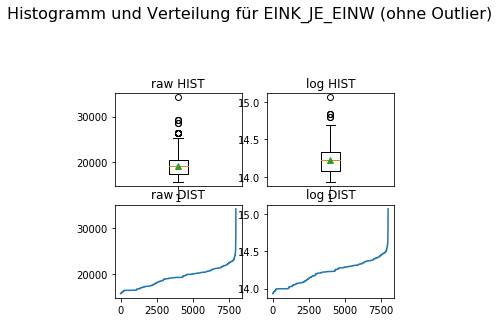

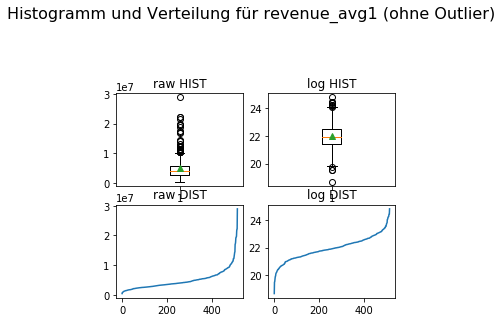

In [7]:
df_gemeinden = df_full_data[df_full_data["Reg_Hier"] == "Gemeinde"]

df_gemeinden[collist] = df_gemeinden[collist].apply(pd.to_numeric)
df_gemeinden[collist].describe()

extract = df_gemeinden.sort_values(by=["BEV_JE_QM"])[:8000]


extract.describe().transpose()

plot_hist_and_dist(extract, collist, "(ohne Outlier)")

subset_with_branches = len(extract[extract["branch_counter_cleaned"] > "0"])
branch_counter = extract["branch_counter_cleaned"].apply(pd.to_numeric).sum()
display("Vorhandene Branches im Subset: " + str(branch_counter)
        + "/ Regionen mit Branches: " + str(subset_with_branches))

<h1>Sukzessive Entfernung der Outlier und Eigenschaften des Subsets</h1>

In [6]:
branches_in_subset = []
regions_with_branches_in_subset = []

for i in range(5000, 11333):
    
    subset = df_gemeinden.sort_values(by=["BEV_JE_QM"])[:i]
    
    branch_counter = subset["branch_counter_cleaned"].apply(pd.to_numeric).sum()
    region_with_branches = len(subset[subset["branch_counter_cleaned"] > "0"])
    
    
    branches_in_subset.append(branch_counter)
    regions_with_branches_in_subset.append(region_with_branches)


Text(0.5,1,'regions_with_branches_in_subset')

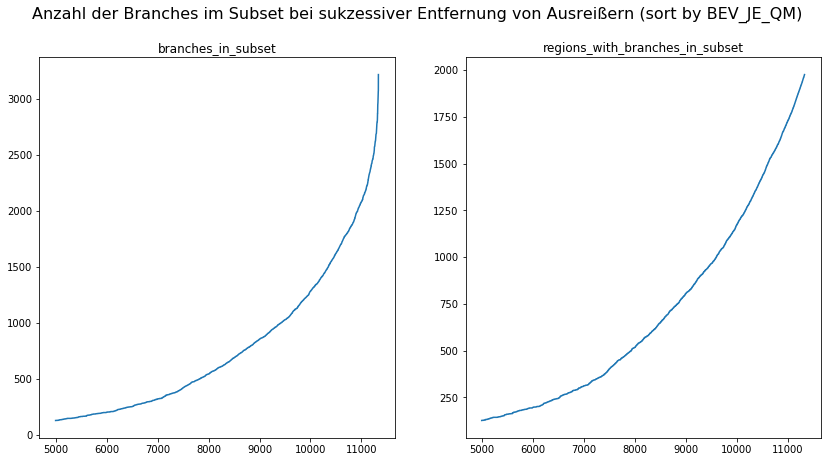

In [16]:
fig = plt.figure(figsize=(14, 7))
    
plt.suptitle("Anzahl der Branches im Subset bei sukzessiver Entfernung von Ausreißern (sort by BEV_JE_QM)", fontsize=16)

ax = plt.subplot(1, 2, 1)

ax.plot(range(5000, 11333), branches_in_subset)
ax.set_title("branches_in_subset")

ax = plt.subplot(1, 2, 2)

ax.plot(range(5000, 11333), regions_with_branches_in_subset)
ax.set_title("regions_with_branches_in_subset")


<h1>Welche Verteilung haben die Inputvariablen der Regionen, für die der Umsatz geschätzt werden soll?</h1>

In [ ]:
df_to_predict = df_gemeinden[df_gemeinden["branch_counter"].isnull()]

collist = ["BEV_INSGESAMT", "osm_nodes_counter", "ANTEIL_SIEDLUNG_VERKEHR", "BEV_JE_QM", "HH_1_4", "EINK_JE_EINW"]

plot_hist_and_dist(df_to_predict, collist, "(regions to predict)") 

In [ ]:
df_labeled = df_gemeinden[~df_gemeinden["branch_counter"].isnull()]

display(df_to_predict.groupby(by="DES").count(), df_labeled.groupby(by="DES").count())

(array([0, 1, 2, 3, 4, 5]), <a list of 6 Text xticklabel objects>)

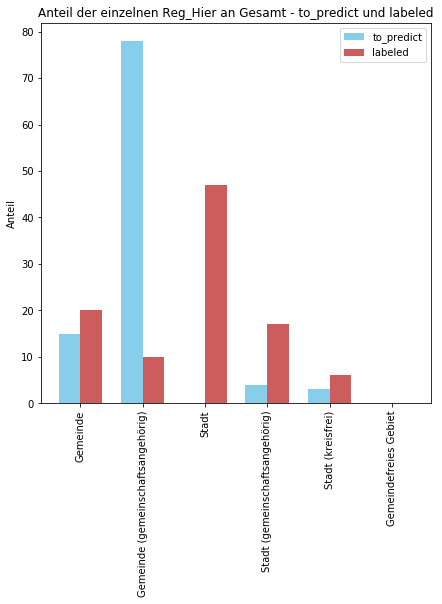

In [24]:
labeled_reg_hier = {}
to_predict_reg_hier = {}


for item in df_labeled.groupby(by="DES"):
    rate = round((len(item[1])/len(df_labeled))*100)
    labeled_reg_hier.update({item[0]: rate})
    
for item in df_to_predict.groupby(by="DES"):
    rate = round((len(item[1])/len(df_to_predict))*100)
    to_predict_reg_hier.update({item[0]: rate})
    
labeled_reg_hier.update({"Gemeindefreies Gebiet": 0})    

ind = np.arange(len(labeled_reg_hier))  # the x locations for the groups
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(7,7))
ax.bar(ind - width/2, list(to_predict_reg_hier.values()), width, color='SkyBlue', label='to_predict')
ax.bar(ind + width/2, list(labeled_reg_hier.values()), width, color='IndianRed', label='labeled')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Anteil')
ax.set_title('Anteil der einzelnen Reg_Hier an Gesamt - to_predict und labeled')
ax.set_xticks(ind)
ax.set_xticklabels(list(labeled_reg_hier.keys()))
ax.legend()
plt.xticks(rotation=90)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


{'gem': 30, 'stadt': 70}

{'gem': 93, 'stadt': 7}

(array([0, 1]), <a list of 2 Text xticklabel objects>)

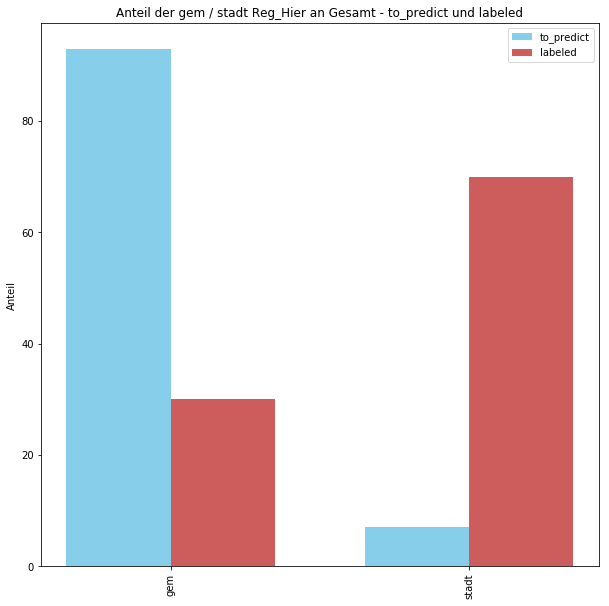

In [25]:
labeled_reg_hier_cumu = {}
to_predict_reg_hier_cumu = {}

df_labeled["DES_cumulated"] = df_labeled["DES"].apply(lambda x: "gem" if "Gemeinde" in x else "stadt")
df_to_predict["DES_cumulated"] = df_to_predict["DES"].apply(lambda x: "gem" if "Gemeinde" in x else "stadt")


for item in df_labeled.groupby(by="DES_cumulated"):
    rate = round((len(item[1])/len(df_labeled))*100)
    labeled_reg_hier_cumu.update({item[0]: rate})
    
for item in df_to_predict.groupby(by="DES_cumulated"):
    rate = round((len(item[1])/len(df_to_predict))*100)
    to_predict_reg_hier_cumu.update({item[0]: rate})
    
display(labeled_reg_hier_cumu, to_predict_reg_hier_cumu)

ind = np.arange(len(labeled_reg_hier_cumu))  # the x locations for the groups
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10,10))
ax.bar(ind - width/2, list(to_predict_reg_hier_cumu.values()), width, color='SkyBlue', label='to_predict')
ax.bar(ind + width/2, list(labeled_reg_hier_cumu.values()), width, color='IndianRed', label='labeled')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Anteil')
ax.set_title('Anteil der gem / stadt Reg_Hier an Gesamt - to_predict und labeled')
ax.set_xticks(ind)
ax.set_xticklabels(list(labeled_reg_hier_cumu.keys()))
ax.legend()
plt.xticks(rotation=90)

In [39]:
df_labeled["DES_cumulated"] = df_labeled["DES"].apply(lambda x: "gem" if "Gemeinde" in x else "stadt")
df_to_predict["DES_cumulated"] = df_to_predict["DES"].apply(lambda x: "gem" if "Gemeinde" in x else "stadt")

df_labeled_gem = df_labeled[df_labeled["DES_cumulated"] == "gem"][collist].apply(pd.to_numeric)
df_labeled_stadt = df_labeled[df_labeled["DES_cumulated"] == "stadt"][collist].apply(pd.to_numeric)

df_to_predict_gem = df_to_predict[df_to_predict["DES_cumulated"] == "gem"][collist].apply(pd.to_numeric)
df_to_predict_stadt = df_to_predict[df_to_predict["DES_cumulated"] == "stadt"][collist].apply(pd.to_numeric)


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


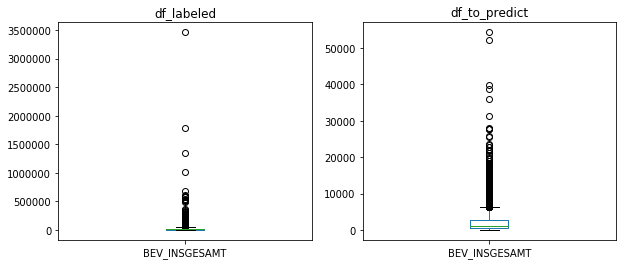

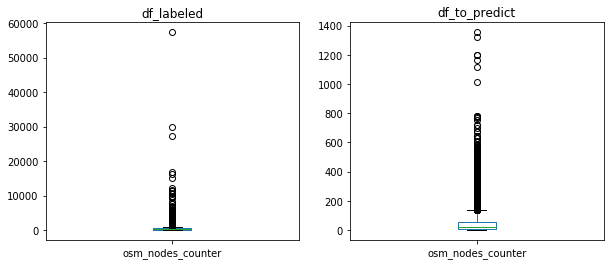

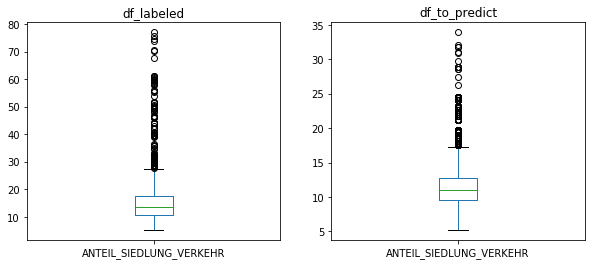

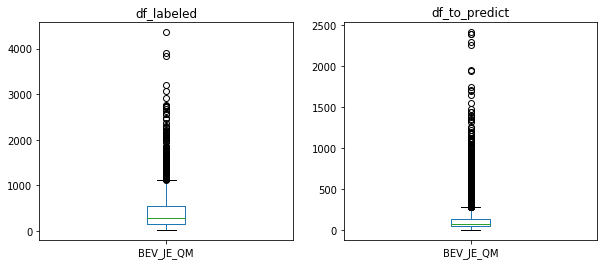

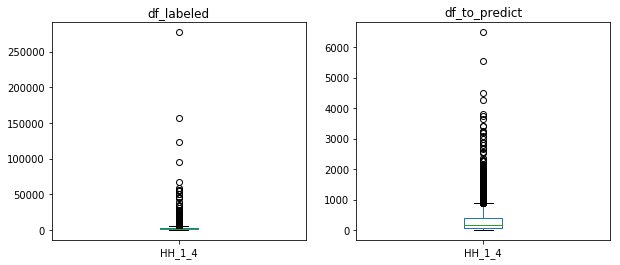

In [40]:
for col in collist[:-1]:    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
      
    axes[0].set_title("df_labeled")
    axes[1].set_title("df_to_predict")

    df_labeled[col].plot.box( ax=axes[0])
    df_to_predict[col].plot.box( ax=axes[1])
    
   

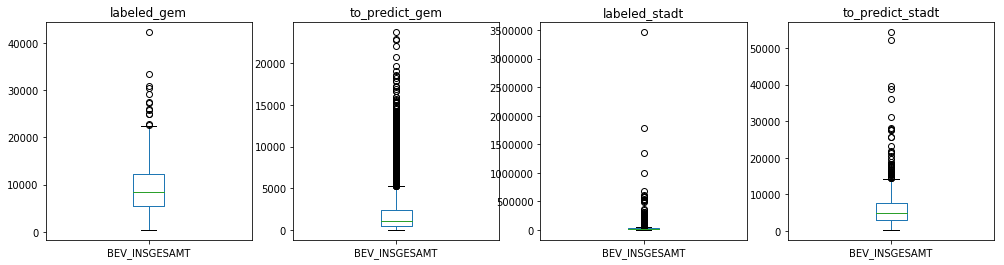

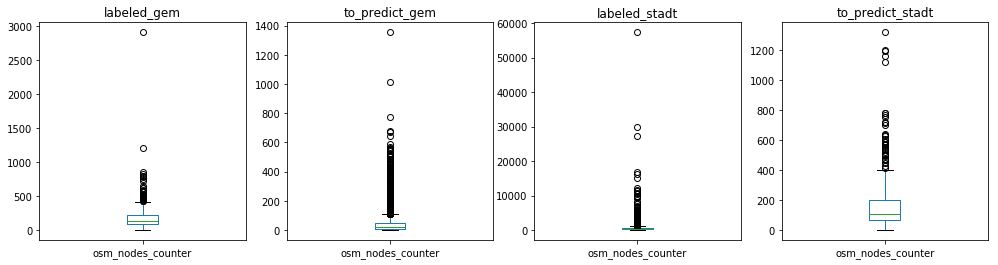

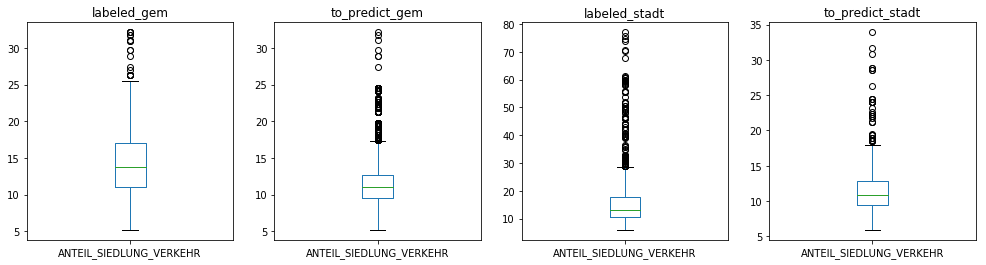

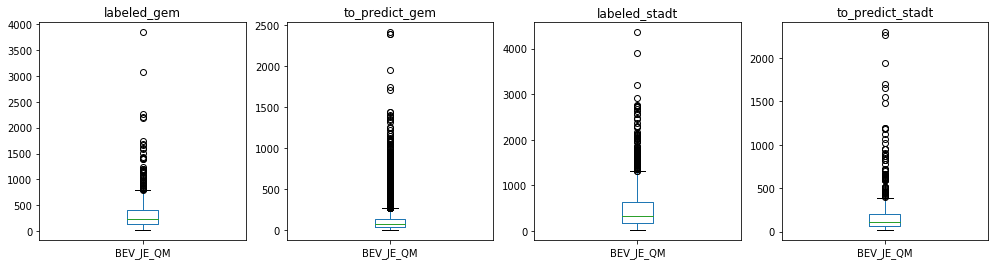

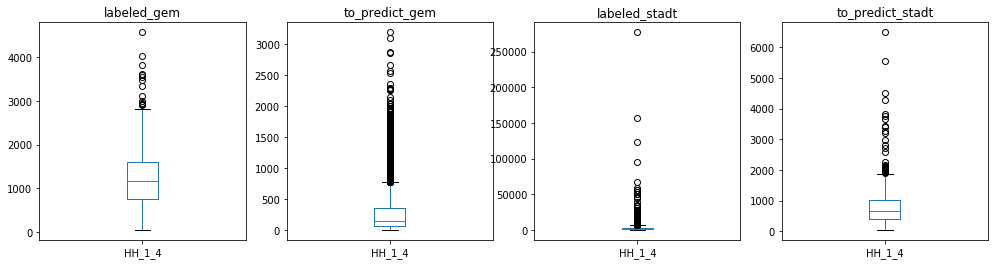

In [41]:
collist = ["BEV_INSGESAMT", "osm_nodes_counter", "ANTEIL_SIEDLUNG_VERKEHR", "BEV_JE_QM", "HH_1_4", "EINK_JE_EINW"]

for col in collist[:-1]:    
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(17,4))
    
    axes[0].set_title("labeled_gem")
    axes[1].set_title("to_predict_gem")

    df_labeled_gem[col].plot.box( ax=axes[0])
    df_to_predict_gem[col].plot.box( ax=axes[1])
    
    axes[2].set_title("labeled_stadt")
    axes[3].set_title("to_predict_stadt")

    df_labeled_stadt[col].plot.box( ax=axes[2])
    df_to_predict_stadt[col].plot.box( ax=axes[3])


In [42]:
df_labeled_gem["BEV_JE_QM"].describe()

count    604.00
mean     345.13
std      363.15
min       23.00
25%      145.00
50%      228.00
75%      408.25
max     3844.00
Name: BEV_JE_QM, dtype: float64

In [43]:
df_to_predict_gem["BEV_JE_QM"].describe()

count   8675.00
mean     118.32
std      145.53
min        2.00
25%       43.00
50%       76.00
75%      135.00
max     2416.00
Name: BEV_JE_QM, dtype: float64

In [44]:
df_labeled_stadt["BEV_JE_QM"].describe()


count   1373.00
mean     495.30
std      498.97
min       23.00
25%      174.00
50%      320.00
75%      631.00
max     4355.00
Name: BEV_JE_QM, dtype: float64

In [45]:
df_to_predict_stadt["BEV_JE_QM"].describe()

count    658.00
mean     191.81
std      254.26
min       18.00
25%       68.00
50%      115.00
75%      197.75
max     2295.00
Name: BEV_JE_QM, dtype: float64

In [32]:
display(len(df_to_predict_gem),len(df_to_predict_stadt), len(df_labeled_gem),len(df_labeled_stadt))

8675

658

604

1396

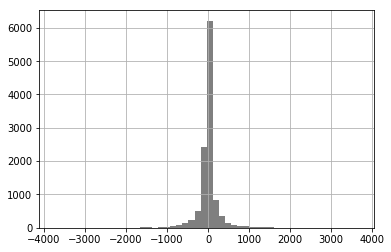

In [181]:
df_gemeinden[collist[3]].diff().hist(color='k', alpha=0.5, bins=50)

<h1>Histogramm und Verteilung Matrixplot (Attribute je Einwohner)</h1>

In [ ]:

#collist = ["BEV_INSGESAMT", "osm_nodes_counter", "ANTEIL_SIEDLUNG_VERKEHR", "BEV_JE_QM", "HH_1_4", "EINK_JE_EINW", "revenue_avg1", "revenue_avg2"]

change_list = ["osm_nodes_counter", "HH_1_4", "revenue_avg1"]


df_gemeinden_attr_per_bev = df_gemeinden.copy()
df_gemeinden_attr_per_bev["revenue_avg1"] = df_gemeinden_attr_per_bev["revenue_avg1"].apply(pd.to_numeric)



for col in change_list:
    df_gemeinden_attr_per_bev[col] = df_gemeinden_attr_per_bev[col] / df_gemeinden_attr_per_bev["BEV_INSGESAMT"]

display(df_gemeinden_attr_per_bev[collist].describe())
    
plot_hist_and_dist(df_gemeinden_attr_per_bev, collist)

<h1>Korrelation zwischen den Inputvariabeln</h1>

,BEV_INSGESAMT,osm_nodes_counter,ANTEIL_SIEDLUNG_VERKEHR,BEV_JE_QM,HH_1_4,EINK_JE_EINW,revenue_avg1
BEV_INSGESAMT,1.00,0.95,0.54,0.53,1.00,0.04,0.97
osm_nodes_counter,0.95,1.00,0.50,0.50,0.94,0.05,0.94
ANTEIL_SIEDLUNG_VERKEHR,0.54,0.50,1.00,0.67,0.56,0.35,0.49
BEV_JE_QM,0.53,0.50,0.67,1.00,0.55,0.26,0.47
HH_1_4,1.00,0.94,0.56,0.55,1.00,0.06,0.96
EINK_JE_EINW,0.04,0.05,0.35,0.26,0.06,1.00,0.05
revenue_avg1,0.97,0.94,0.49,0.47,0.96,0.05,1.00


7


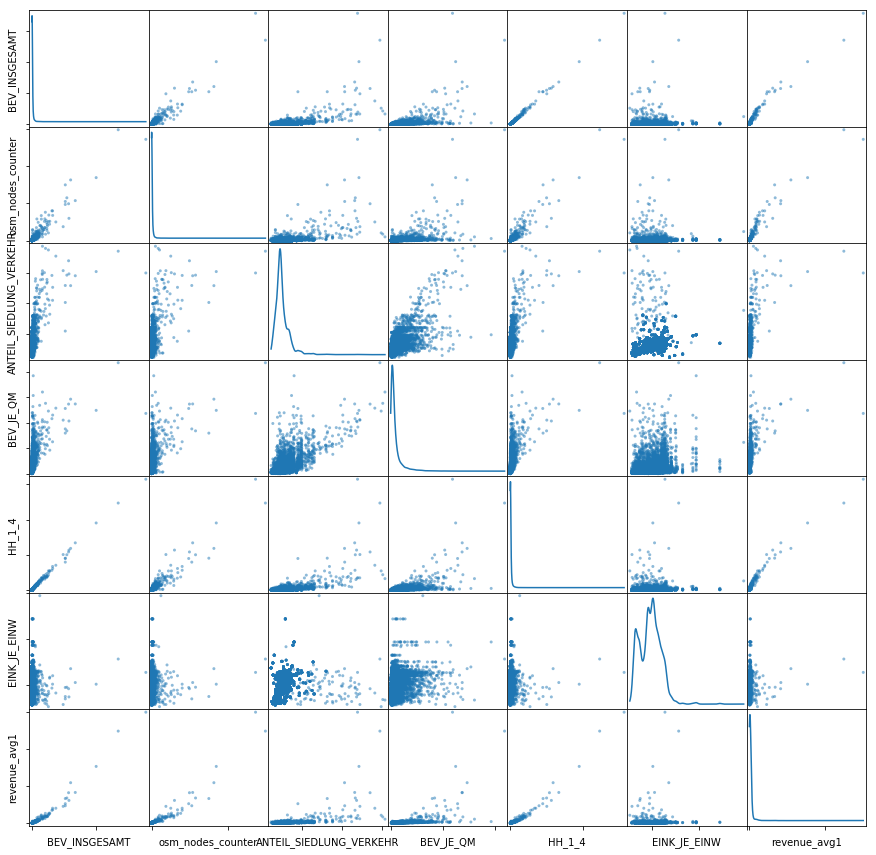

In [43]:
collist = ["BEV_INSGESAMT", "osm_nodes_counter", "ANTEIL_SIEDLUNG_VERKEHR", "BEV_JE_QM", "HH_1_4", 
           "ANTEIL_ARBEITSLOSE", "EINK_JE_EINW", "revenue_avg1"]

sampled_data = df_gemeinden[collist].sample(frac=0.8, replace=False)

display(sampled_data.corr(method="pearson"))

axs = pd.plotting.scatter_matrix(sampled_data, figsize=(15, 15), diagonal='kde')
n = len(sampled_data.columns) -1
print(n)
for i in range(n):
    for j in range(n):
        axs[i,j].set_xticklabels(())
        axs[i,j].set_yticklabels(())
        
        #axs[i,j].tick_params(labelrotation=90.0)
        #axs[i,j].tick_params(labelrotation=0.0)
        #axs[i,j].xaxis.set_rotation(0)
        #axs[i,j].yaxis.set_rotation(90)


,BEV_INSGESAMT,osm_nodes_counter,ANTEIL_SIEDLUNG_VERKEHR,BEV_JE_QM,HH_1_4,EINK_JE_EINW,revenue_avg1,revenue_avg2
BEV_INSGESAMT,1.00,-0.02,0.46,0.47,-0.15,0.03,-0.00,0.97
osm_nodes_counter,-0.02,1.00,-0.05,-0.07,-0.03,0.03,0.73,0.00
ANTEIL_SIEDLUNG_VERKEHR,0.46,-0.05,1.00,0.68,-0.18,0.35,-0.09,0.38
BEV_JE_QM,0.47,-0.07,0.68,1.00,-0.29,0.26,0.03,0.40
HH_1_4,-0.15,-0.03,-0.18,-0.29,1.00,0.06,0.10,-0.15
EINK_JE_EINW,0.03,0.03,0.35,0.26,0.06,1.00,0.22,0.01
revenue_avg1,-0.00,0.73,-0.09,0.03,0.10,0.22,1.00,0.06
revenue_avg2,0.97,0.00,0.38,0.40,-0.15,0.01,0.06,1.00


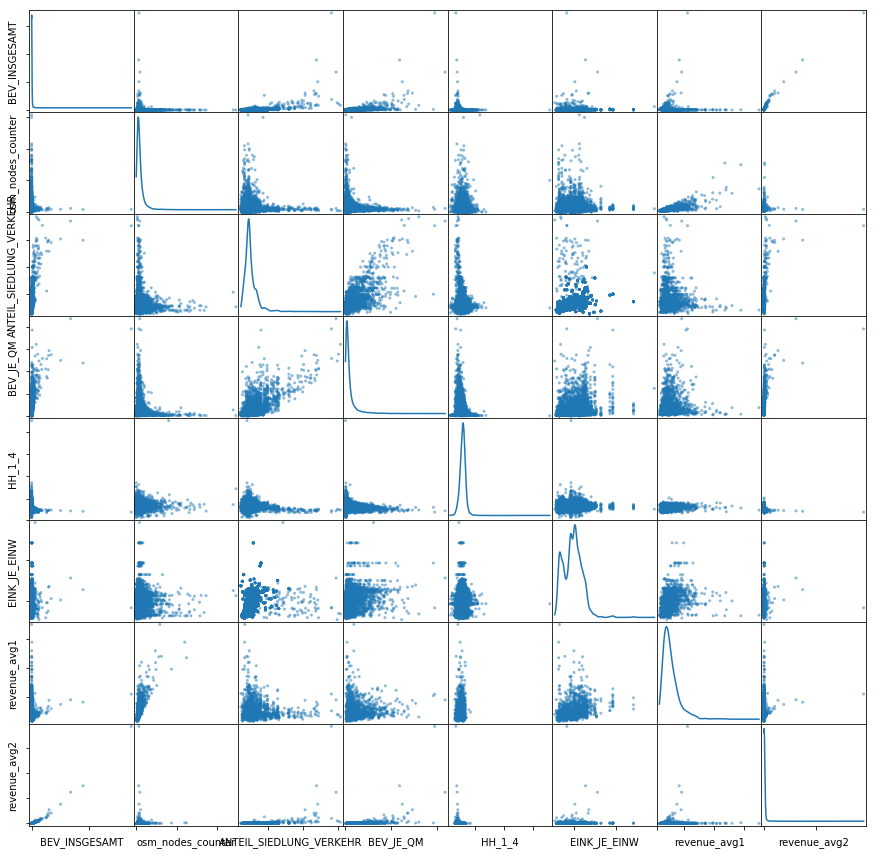

In [42]:
collist = ["BEV_INSGESAMT", "osm_nodes_counter", "ANTEIL_SIEDLUNG_VERKEHR", "BEV_JE_QM", "HH_1_4", 
           "ANTEIL_ARBEITSLOSE", "EINK_JE_EINW", "revenue_avg1", "revenue_avg2"]

sampled_data = df_gemeinden_attr_per_bev[collist].sample(frac=0.8, replace=False)

display(sampled_data.corr(method="pearson"))

axs = pd.plotting.scatter_matrix(sampled_data, figsize=(15, 15), diagonal='kde')
n = len(sampled_data.columns) -1
for i in range(n):
    for j in range(n):
        axs[i,j].set_xticklabels(())
        axs[i,j].set_yticklabels(())
        
        #axs[i,j].tick_params(labelrotation=90.0)
        #axs[i,j].tick_params(labelrotation=0.0)
        #axs[i,j].xaxis.set_rotation(0)
        #axs[i,j].yaxis.set_rotation(90)

<h2>Outliers entfernen: 5% und 95% Percentile</h2>

C:\Anaconda3\lib\site-packages\pandas\plotting\_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


Index des 0.1 Percentil: 1133 - Index des 0.9 Percentil: 10199 (BEV_INSGESAMT) 
Value des 0.1 Percentil: 281 - Value des 0.9 Percentil: 13266 (BEV_INSGESAMT) 
Anzahl Rows nach Entfernung der Outlier: 9070


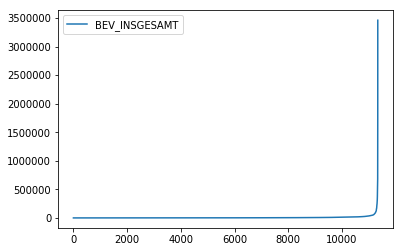

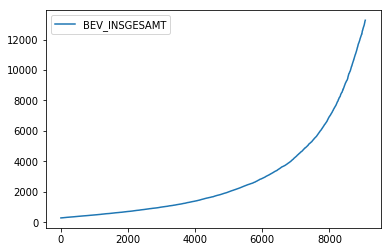

In [180]:
sorting_attribut = "BEV_INSGESAMT"
lower_percentil_border = 0.1
upper_percentil_border = 0.9

df_gemeinden_sorted = df_gemeinden.sort_values(by=[sorting_attribut], axis="index").reset_index()

df_gemeinden_sorted.plot(x=np.arange(len(df_gemeinden)), y=[sorting_attribut])

lower_percentil = int(len(df_gemeinden_sorted)*lower_percentil_border)
upper_percentil = int(len(df_gemeinden_sorted)*upper_percentil_border)
print("Index des " + str(lower_percentil_border) + " Percentil: " + str(lower_percentil) + " - Index des " + str(upper_percentil_border) + " Percentil: " + str(upper_percentil) +  " (" + sorting_attribut + ") ")

percentil_lower_value = df_gemeinden_sorted[sorting_attribut].loc[lower_percentil]
percentil_upper_value = df_gemeinden_sorted[sorting_attribut].loc[upper_percentil]

print("Value des " + str(lower_percentil_border) + " Percentil: " + str(percentil_lower_value) + " - Value des " + str(upper_percentil_border) + " Percentil: "  + str(percentil_upper_value) + " (" + sorting_attribut + ") ")

cond = df_gemeinden_sorted[sorting_attribut].between(percentil_lower_value, percentil_upper_value)


df_gemeinden_del_outliers = df_gemeinden_sorted[cond]
      
print("Anzahl Rows nach Entfernung der Outlier: " + str(len(df_gemeinden_del_outliers)))

df_gemeinden_del_outliers.plot(x=np.arange(len(df_gemeinden_del_outliers)), y=[sorting_attribut])




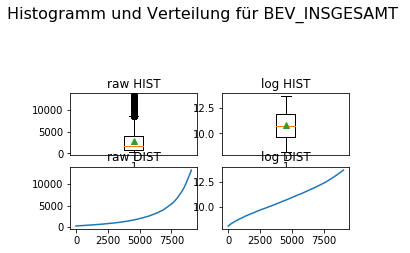

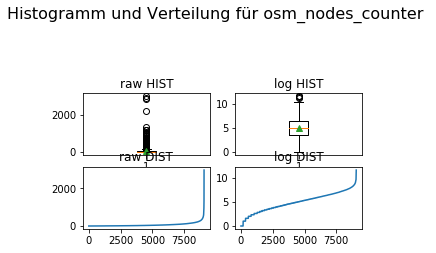

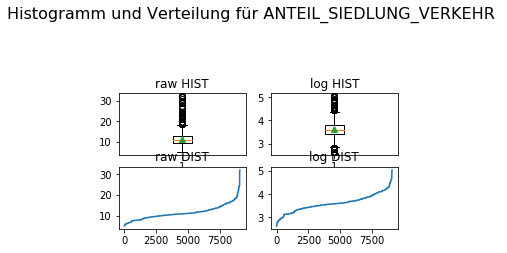

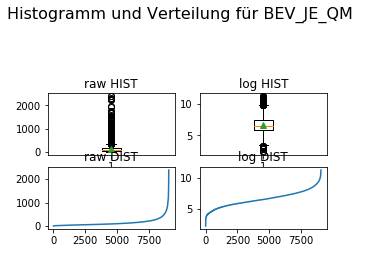

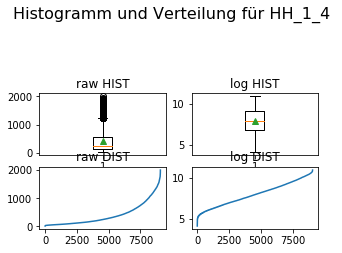

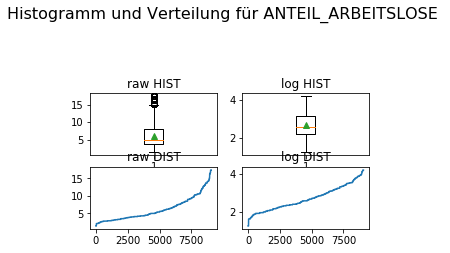

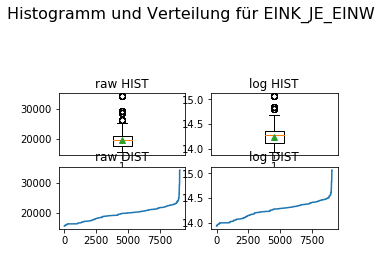

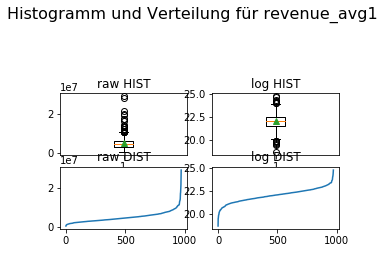

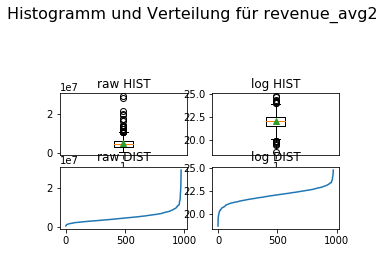

In [181]:
plot_hist_and_dist(df_gemeinden_del_outliers, collist)


In [118]:
percentil_5_value

23017

In [ ]:
collist = ["BEV_INSGESAMT", "osm_nodes_counter", "ANTEIL_SIEDLUNG_VERKEHR", "BEV_JE_QM", "HH_1_4", 
           "ANTEIL_ARBEITSLOSE", "EINK_JE_EINW", "revenue_avg1", "revenue_avg2"]

df_gemeinden_del_outliers = df_gemeinden[np.abs(df.Data-df.Data.mean()) <= (3*df.Data.std())]

sampled_data = df_gemeinden_attr_per_bev[collist].sample(frac=0.8, replace=False)

display(sampled_data.corr(method="pearson"))

axs = pd.plotting.scatter_matrix(sampled_data, figsize=(15, 15), diagonal='kde')
n = len(sampled_data.columns) -1
for i in range(n):
    for j in range(n):
        axs[i,j].set_xticklabels(())
        axs[i,j].set_yticklabels(())
        
        #axs[i,j].tick_params(labelrotation=90.0)
        #axs[i,j].tick_params(labelrotation=0.0)
        #axs[i,j].xaxis.set_rotation(0)
        #axs[i,j].yaxis.set_rotation(90)

In [152]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()

collist = ["BEV_INSGESAMT", "osm_nodes_counter", "ANTEIL_SIEDLUNG_VERKEHR", "BEV_JE_QM", "HH_1_4", 
           "ANTEIL_ARBEITSLOSE", "EINK_JE_EINW", "revenue_avg1", "revenue_avg2"]


df_gemeinden_scaled = df_gemeinden[~df_gemeinden["HH_1_4"].isnull()][collist].copy()

df_gemeinden_scaled[["BEV_INSGESAMT", "osm_nodes_counter", "ANTEIL_SIEDLUNG_VERKEHR", "BEV_JE_QM", "HH_1_4", "EINK_JE_EINW"]] = scaler.fit_transform(df_gemeinden_scaled[["BEV_INSGESAMT", "osm_nodes_counter", "ANTEIL_SIEDLUNG_VERKEHR", "BEV_JE_QM", "HH_1_4", "EINK_JE_EINW"]])




display(df_gemeinden_scaled.describe(), df_gemeinden.describe())

,BEV_INSGESAMT,osm_nodes_counter,ANTEIL_SIEDLUNG_VERKEHR,BEV_JE_QM,HH_1_4,EINK_JE_EINW,revenue_avg1
count,11320.00,11320.00,11320.00,11320.00,11320.00,11320.00,1977.00
mean,1.24,1.16,0.31,0.64,0.93,-0.05,16414215.23
std,10.47,8.89,1.31,1.96,6.53,0.69,102878319.84
min,-0.38,-0.33,-1.51,-0.65,-0.39,-1.40,426378.41
25%,-0.23,-0.23,-0.36,-0.30,-0.25,-0.58,4258888.15
50%,0.00,0.00,0.00,0.00,0.00,0.00,6904151.52
75%,0.77,0.77,0.64,0.70,0.75,0.42,11117643.51
max,776.92,602.87,16.90,30.39,444.80,6.07,3860352543.22


,HH_1_4,EINK_JE_EINW,ANTEIL_SIEDLUNG_VERKEHR,BEV_INSGESAMT,BEV_JE_QM,osm_nodes_counter,revenue_avg1
count,11320.00,11333.00,11333.00,11333.00,11333.00,11333.00,1977.00
mean,826.84,19613.74,12.30,7202.78,182.11,141.42,16414215.23
std,4065.55,2215.55,5.12,46605.23,274.20,843.92,102878319.84
min,3.00,15259.00,5.20,8.00,2.00,0.00,426378.41
25%,90.00,17893.00,9.70,632.00,51.00,9.00,4258888.15
50%,246.50,19771.00,11.10,1675.00,93.00,31.00,6904151.52
75%,712.25,21116.00,13.60,5077.00,191.00,104.00,11117643.51
max,277026.00,39351.00,77.00,3460725.00,4355.00,57304.00,3860352543.22


C:\Anaconda3\lib\site-packages\pandas\plotting\_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


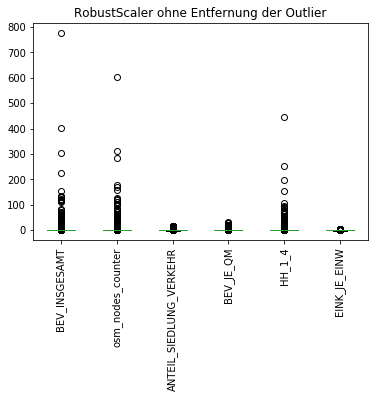

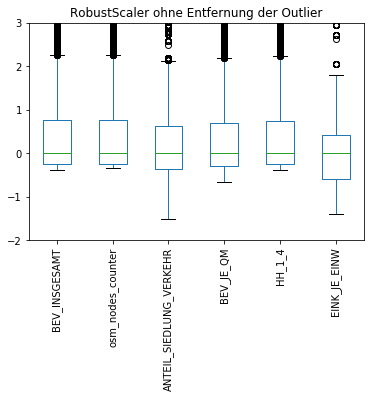

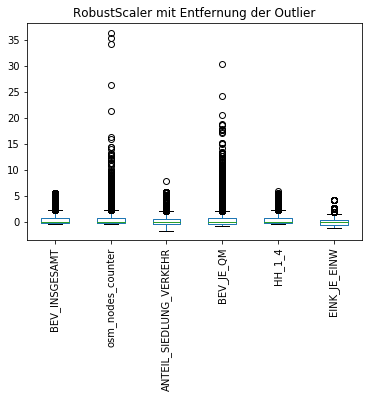

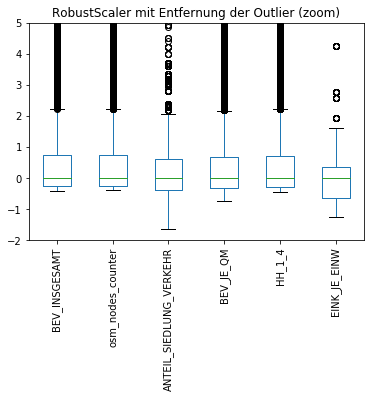

In [178]:
df_gemeinden_scaled.plot(title="RobustScaler ohne Entfernung der Outlier",rot=90,kind="box", y=["BEV_INSGESAMT", "osm_nodes_counter", "ANTEIL_SIEDLUNG_VERKEHR", "BEV_JE_QM", "HH_1_4", "EINK_JE_EINW"])
df_gemeinden_scaled.plot(title="RobustScaler ohne Entfernung der Outlier",ylim=(-2,3), rot=90,kind="box", y=["BEV_INSGESAMT", "osm_nodes_counter", "ANTEIL_SIEDLUNG_VERKEHR", "BEV_JE_QM", "HH_1_4", "EINK_JE_EINW"])

df_gemeinden_del_outliers_scaled = df_gemeinden_del_outliers.copy()

df_gemeinden_del_outliers_scaled[["BEV_INSGESAMT", "osm_nodes_counter", "ANTEIL_SIEDLUNG_VERKEHR", "BEV_JE_QM", "HH_1_4", "EINK_JE_EINW"]] = scaler.fit_transform(df_gemeinden_del_outliers[["BEV_INSGESAMT", "osm_nodes_counter", "ANTEIL_SIEDLUNG_VERKEHR", "BEV_JE_QM", "HH_1_4", "EINK_JE_EINW"]])

df_gemeinden_del_outliers_scaled.plot(title="RobustScaler mit Entfernung der Outlier", rot=90,kind="box", y=["BEV_INSGESAMT", "osm_nodes_counter", "ANTEIL_SIEDLUNG_VERKEHR", "BEV_JE_QM", "HH_1_4", "EINK_JE_EINW"])
df_gemeinden_del_outliers_scaled.plot(title="RobustScaler mit Entfernung der Outlier (zoom)" ,ylim=(-2,5), rot=90,kind="box", y=["BEV_INSGESAMT", "osm_nodes_counter", "ANTEIL_SIEDLUNG_VERKEHR", "BEV_JE_QM", "HH_1_4", "EINK_JE_EINW"])

<h1>Variablen austauschen</h1>

<h2>osm_nodes kann raus, da hohe Korrelation mit HH_1_4 (0.94) mit Outlier. Zudem hat trotz Entfernung der Outlier osm_nodes eine hohe Ausreißerquote - HH_1_4 dagegen weniger</h2>

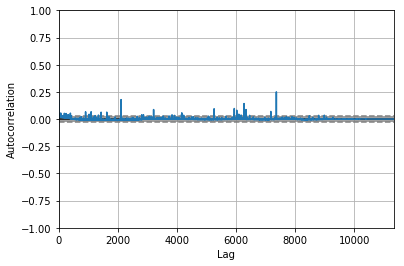

In [120]:
pd.plotting.autocorrelation_plot(df_gemeinden["BEV_INSGESAMT"])

<h1>Log Funktionen und Invertierung</h1>
<img src="https://www.math.uni-bielefeld.de/~ringel/lectures/paderborn/exp-log.gif">

In [3]:
df_gemeinden = df_full_data[df_full_data["Reg_Hier"] == "Gemeinde"]


array(['Stadt (kreisfrei)', 'Stadt', 'Gemeinde (gemeinschaftsangehörig)',
       'Stadt (gemeinschaftsangehörig)', 'Gemeinde',
       'Gemeindefreies Gebiet'], dtype=object)

In [4]:
df_to_predict = df_gemeinden[df_gemeinden["revenue_avg1"].isnull()].copy()
df_labeled = df_gemeinden[~df_gemeinden["revenue_avg1"].isnull()].copy()

In [17]:
df_to_predict["BEV_JE_QM"].describe()


count   9356.00
mean     125.62
std      163.57
min        2.00
25%       45.00
50%       78.00
75%      140.00
max     2416.00
Name: BEV_JE_QM, dtype: float64

In [19]:
df_labeled["BEV_JE_QM"].describe()

count   1977.00
mean     449.42
std      466.79
min       23.00
25%      161.00
50%      285.00
75%      546.00
max     4355.00
Name: BEV_JE_QM, dtype: float64

C:\Anaconda3\lib\site-packages\pandas\plotting\_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


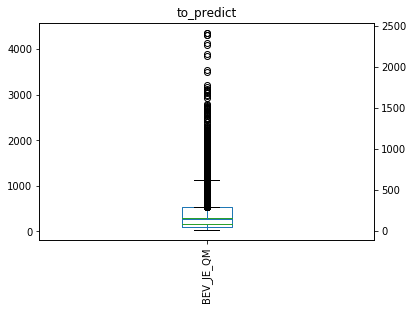

In [34]:
ax = df_labeled.plot(title="labeled", rot=90, kind="box", y=["BEV_JE_QM"])
df_to_predict.plot(title="to_predict", rot=90, kind="box", y=["BEV_JE_QM"], ax=ax, secondary_y=True, sharex=False)


C:\Anaconda3\lib\site-packages\pandas\plotting\_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


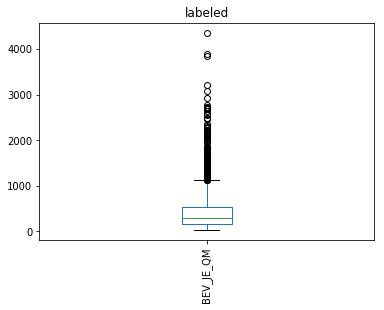

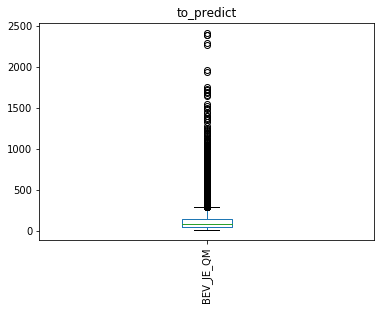

In [35]:
df_labeled.plot(title="labeled", rot=90, kind="box", y=["BEV_JE_QM"])
df_to_predict.plot(title="to_predict", rot=90, kind="box", y=["BEV_JE_QM"])


In [ ]:
df_labeled.plot(title="labeled", rot=90, kind="box", y=["BEV_JE_QM"])
df_to_predict.plot(title="to_predict", rot=90, kind="box", y=["BEV_JE_QM"])


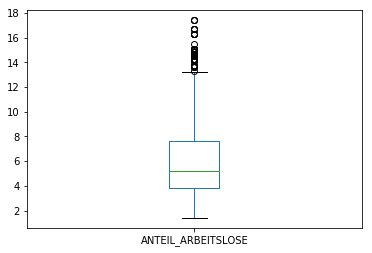

In [12]:
df_labeled["ANTEIL_ARBEITSLOSE"].plot(kind="box")

In [46]:
df_labeled["BEV_JE_QM"].describe()

count   1977.00
mean     449.42
std      466.79
min       23.00
25%      161.00
50%      285.00
75%      546.00
max     4355.00
Name: BEV_JE_QM, dtype: float64

In [47]:
df_to_predict["BEV_JE_QM"].describe()

count   9333.00
mean     123.50
std      156.82
min        2.00
25%       45.00
50%       78.00
75%      140.00
max     2416.00
Name: BEV_JE_QM, dtype: float64

In [6]:
#df_sorted = df_gemeinden.sort_values(by=["BEV_JE_QM"], ascending=False)
df_sorted = df_gemeinden.sort_values(by=["BEV_INSGESAMT"], ascending=False)

In [8]:
df_sorted[["Name", "BEV_INSGESAMT","BEV_JE_QM", "DES"]]

,Name,BEV_INSGESAMT,BEV_JE_QM,DES
8571,"Berlin, Stadt",3460725,3899,Stadt (kreisfrei)
1122,"Hamburg, Freie und Hansestadt",1786448,2366,Stadt (kreisfrei)
6438,"München, Landeshauptstadt",1353186,4355,Stadt (kreisfrei)
2237,"Köln, Stadt",1007119,2486,Stadt (kreisfrei)
2579,"Frankfurt am Main, Stadt",679664,2737,Stadt (kreisfrei)
5326,"Stuttgart, Landeshauptstadt",606588,2925,Stadt (kreisfrei)
2159,"Düsseldorf, Stadt",588735,2710,Stadt (kreisfrei)
2491,"Dortmund, Stadt",580444,2068,Stadt (kreisfrei)
2163,"Essen, Stadt",574635,2732,Stadt (kreisfrei)
2156,"Bremen, Stadt",547340,1682,Stadt (kreisfrei)


In [9]:
df_sorted[df_sorted["branch_counter"].isnull()][["Name", "BEV_JE_QM" ,"BEV_INSGESAMT", "DES", "branch_counter"]]

,Name,BEV_JE_QM,BEV_INSGESAMT,DES,branch_counter
2210,"Meerbusch, Stadt",844,54318,Stadt,nan
2644,"Bad Homburg v. d. Höhe, Stadt",1021,52229,Stadt,nan
2332,"Siegburg, Stadt",1696,39746,Stadt,nan
7655,Schwabach,952,38879,Stadt (kreisfrei),nan
2721,"Neu-Isenburg, Stadt",1482,36034,Stadt,nan
5343,"Herrenberg, Stadt",476,31292,Stadt (gemeinschaftsangehörig),nan
2506,"Wetter (Ruhr), Stadt",893,28113,Stadt,nan
2693,"Kelkheim (Taunus), Stadt",910,27883,Stadt,nan
2224,"Hamminkeln, Stadt",169,27711,Stadt,nan
2916,"Baunatal, Stadt",722,27642,Stadt,nan


In [10]:
df_gemeinden[df_gemeinden["BEV_INSGESAMT"].between(374, 54318)].count()
#df_gemeinden[df_gemeinden["BEV_JE_QM"].between(23, 2416, inclusive=True)].count()

AGS_12                    9571
RS_Land                   9571
RS_RB_NUTS2               9571
RS_Kreis                  9571
RS_VB                     9571
RS_Gem                    9571
Name                      9571
Reg_Hier                  9571
HH_1_1                    9571
HH_1_2                    9571
HH_1_3                    9571
HH_1_4                    9571
HH_1_5                    9567
HH_2_1                    9571
HH_2_2                    9571
HH_2_3                    9571
HH_2_5                    9555
HH_2_6                    9556
HH_3_1                    9571
HH_3_2                    9571
HH_3_3                    9571
HH_3_4                    9571
HH_3_5                    9571
HH_3_6                    9476
HH_3_7                    9055
HH_4_1                    9571
HH_4_2                    9571
HH_4_3                    9571
HH_4_4                    9571
FAM_1_1                   9571
                          ... 
BEV_WEIBLICH              9571
BEV_JE_Q

In [74]:
df_gemeinden.count()

AGS_12                    11333
RS_Land                   11333
RS_RB_NUTS2               11333
RS_Kreis                  11333
RS_VB                     11333
RS_Gem                    11333
Name                      11333
Reg_Hier                  11333
HH_1_1                    11332
HH_1_2                    11302
HH_1_3                    11310
HH_1_4                    11320
HH_1_5                    11089
HH_2_1                    11332
HH_2_2                    11302
HH_2_3                    11331
HH_2_5                    11047
HH_2_6                    10963
HH_3_1                    11332
HH_3_2                    11302
HH_3_3                    11315
HH_3_4                    11276
HH_3_5                    11249
HH_3_6                    10799
HH_3_7                    10016
HH_4_1                    11332
HH_4_2                    11284
HH_4_3                    11257
HH_4_4                    11327
FAM_1_1                   11332
                          ...  
BEV_WEIB

AGS_12                    9571
RS_Land                   9571
RS_RB_NUTS2               9571
RS_Kreis                  9571
RS_VB                     9571
RS_Gem                    9571
Name                      9571
Reg_Hier                  9571
HH_1_1                    9571
HH_1_2                    9571
HH_1_3                    9571
HH_1_4                    9571
HH_1_5                    9567
HH_2_1                    9571
HH_2_2                    9571
HH_2_3                    9571
HH_2_5                    9555
HH_2_6                    9556
HH_3_1                    9571
HH_3_2                    9571
HH_3_3                    9571
HH_3_4                    9571
HH_3_5                    9571
HH_3_6                    9476
HH_3_7                    9055
HH_4_1                    9571
HH_4_2                    9571
HH_4_3                    9571
HH_4_4                    9571
FAM_1_1                   9571
                          ... 
BEV_WEIBLICH              9571
BEV_JE_Q

In [6]:
df_extract = df_gemeinden[df_gemeinden["BEV_INSGESAMT"].between(374, 54318)].copy()
#df_extract = df_gemeinden[df_gemeinden["BEV_JE_QM"].between(23, 2416, inclusive=True)]

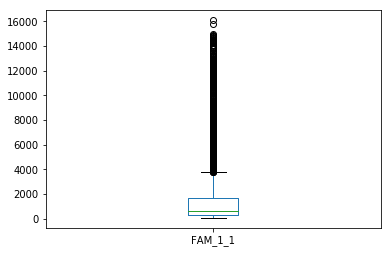

In [123]:
df_extract["FAM_1_1"].plot(kind="box")
#df_gemeinden["FAM_1_1"].plot(kind="box")

In [9]:
df_extract["Regionstyp"] = df_extract["DES"].apply(lambda x: "gem" if "Gemeinde" in x else "stadt")

df_extract_gem = df_extract[df_extract["Regionstyp"] == "gem"].copy()

df_extract_stadt = df_extract[df_extract["Regionstyp"] == "stadt"].copy()

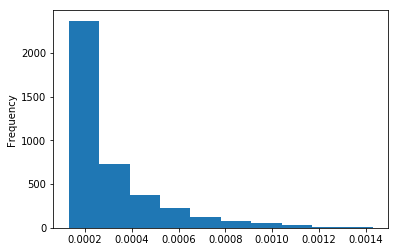

In [38]:
(df_extract_gem["BEV_INSGESAMT").plot(kind = "hist")

In [54]:
df_extract.groupby("Regionstyp")["BEV_INSGESAMT"].describe().transpose()


Regionstyp,gem,stadt
count,7683.00,1888.00
mean,2863.58,14659.78
std,3425.18,11892.21
min,374.00,482.00
25%,811.00,5531.00
50%,1579.00,11025.00
75%,3399.50,20552.75
max,42213.00,54318.00


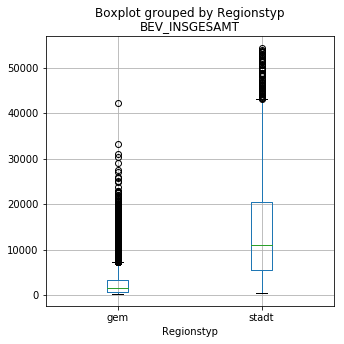

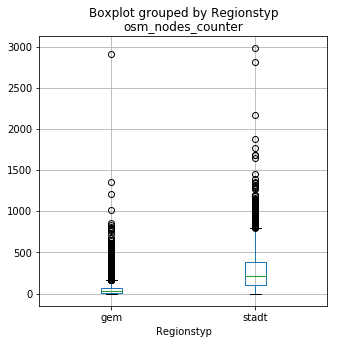

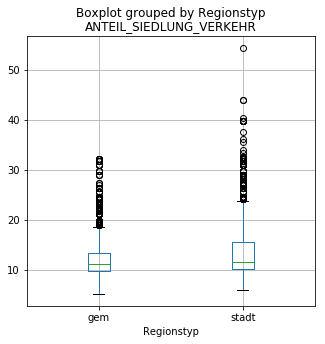

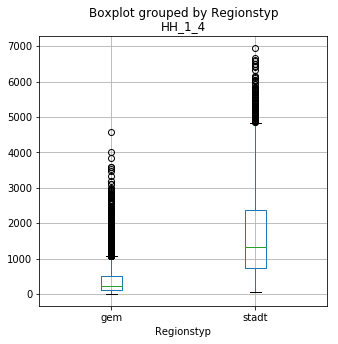

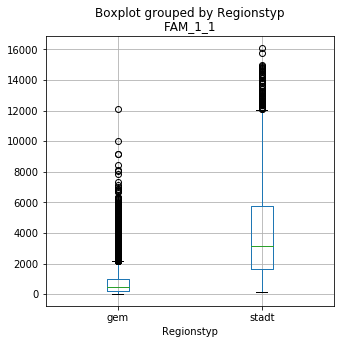

In [85]:
df_extract.boxplot(column=["BEV_INSGESAMT"], by="Regionstyp",figsize=(5,5))
df_extract.boxplot(column=["osm_nodes_counter"], by="Regionstyp",figsize=(5,5))
df_extract.boxplot(column=["ANTEIL_SIEDLUNG_VERKEHR"], by="Regionstyp",figsize=(5,5))
df_extract.boxplot(column=["HH_1_4"], by="Regionstyp",figsize=(5,5))
df_extract.boxplot(column=["FAM_1_1"], by="Regionstyp",figsize=(5,5))

#constant_array = pd.Series([3399] * len(df_extract))
#constant_array.plot.line(subplots=True, color= "red")

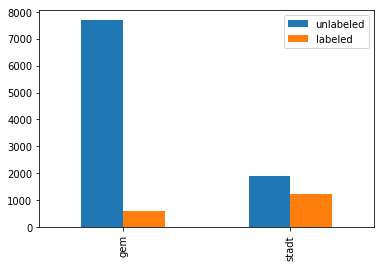

In [32]:
gem_gesamt, gem_with_label = len(df_extract[df_extract["Regionstyp"] == "gem"]) , df_extract[df_extract["Regionstyp"] == "gem"]["revenue_avg1"].count()

stadt_gesamt, stadt_with_label = len(df_extract[df_extract["Regionstyp"] == "stadt"]) ,df_extract[df_extract["Regionstyp"] == "stadt"]["revenue_avg1"].count()

df_temp = pd.DataFrame({"gem" : [gem_gesamt, gem_with_label], "stadt": [stadt_gesamt, stadt_with_label]}, index=["unlabeled", "labeled"])

df_temp.transpose().plot.bar()

In [33]:
df_temp.transpose()

,unlabeled,labeled
gem,7683,604
stadt,1888,1221


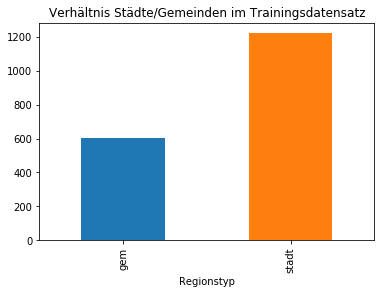

In [106]:
df_labeled.groupby(by="Regionstyp")["Name"].count().plot(kind = "bar", title= "Verhältnis Städte/Gemeinden im Trainingsdatensatz")

In [7]:
df_to_predict = df_extract[df_extract["revenue_avg1"].isnull()].copy()
df_labeled = df_extract[~df_extract["revenue_avg1"].isnull()].copy()

Rectangle(xy=(-0.25, 0), width=0.5, height=7079, angle=0)
Rectangle(xy=(0.75, 0), width=0.5, height=667, angle=0)


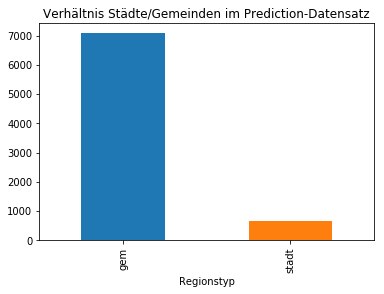

In [105]:
ax = df_to_predict.groupby(by="Regionstyp")["Name"].count().plot(kind = "bar", title= "Verhältnis Städte/Gemeinden im Prediction-Datensatz")
7079 667
for p in ax.patches:
    print(p)

In [156]:
df_labeled_gem = df_labeled[df_labeled["Regionstyp"] == "gem"].copy()
df_labeled_stadt = df_labeled[df_labeled["Regionstyp"] == "stadt"].copy()

df_to_predict_gem = df_to_predict[df_to_predict["Regionstyp"] == "gem"].copy()
df_to_predict_stadt = df_to_predict[df_to_predict["Regionstyp"] == "stadt"].copy()

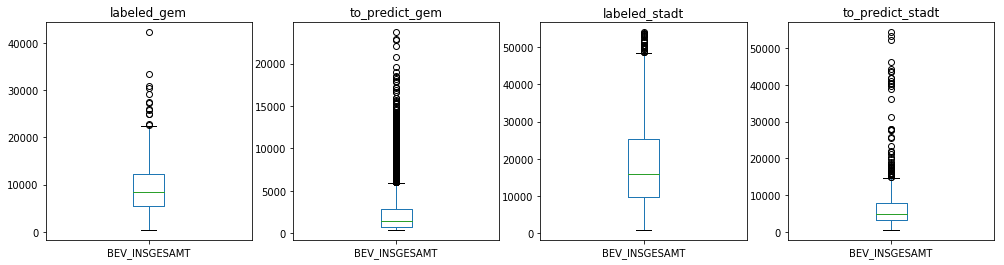

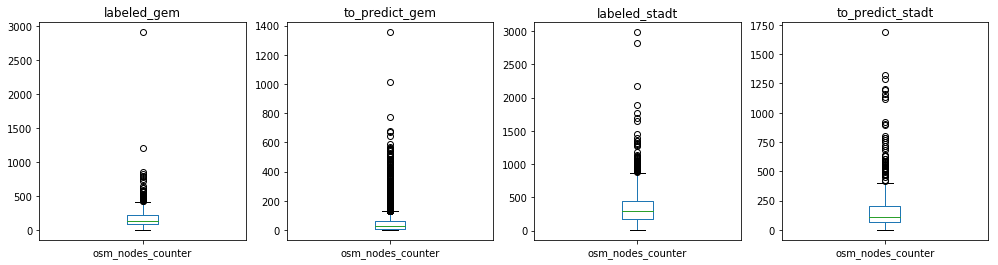

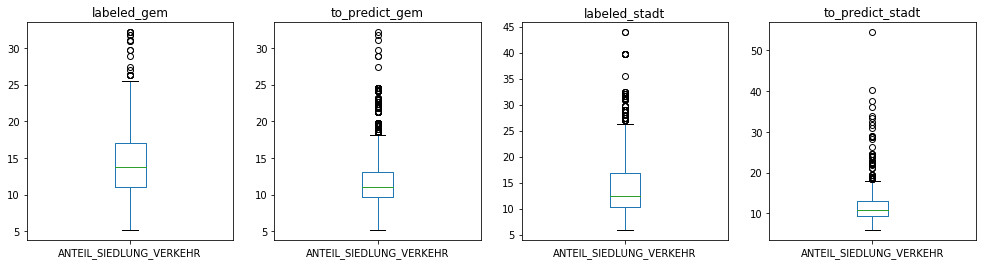

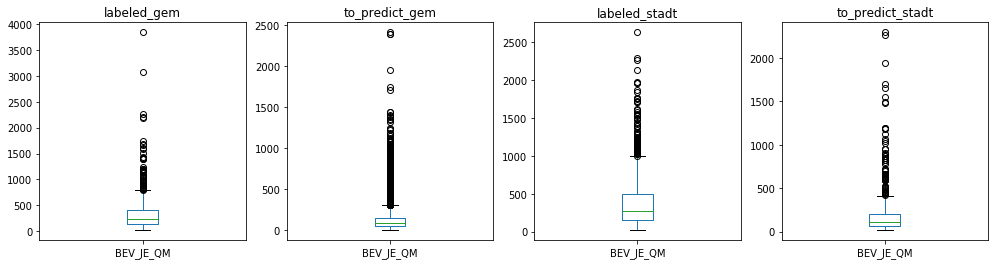

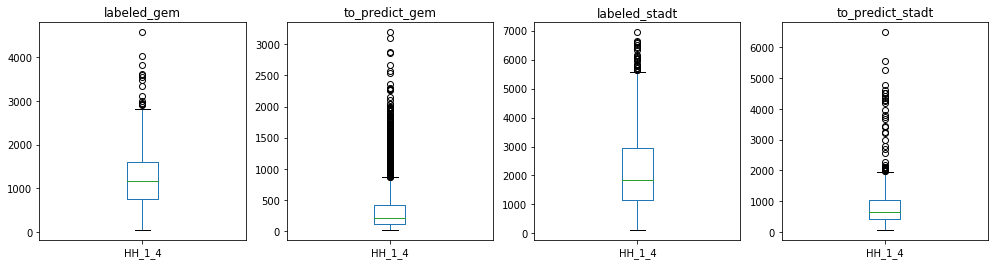

In [157]:
collist = ["BEV_INSGESAMT", "osm_nodes_counter", "ANTEIL_SIEDLUNG_VERKEHR", "BEV_JE_QM", "HH_1_4", "EINK_JE_EINW"]

for col in collist[:-1]:    
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(17,4))
    
    axes[0].set_title("labeled_gem")
    axes[1].set_title("to_predict_gem")

    df_labeled_gem[col].plot.box( ax=axes[0])
    df_to_predict_gem[col].plot.box( ax=axes[1])
    
    axes[2].set_title("labeled_stadt")
    axes[3].set_title("to_predict_stadt")

    df_labeled_stadt[col].plot.box( ax=axes[2])
    df_to_predict_stadt[col].plot.box( ax=axes[3])


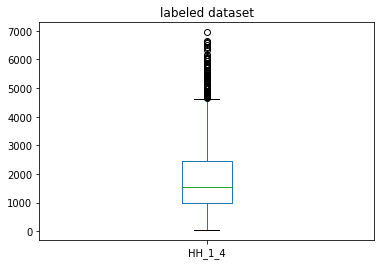

In [171]:
df_labeled["HH_1_4"].plot( kind = "box", title= "labeled dataset")


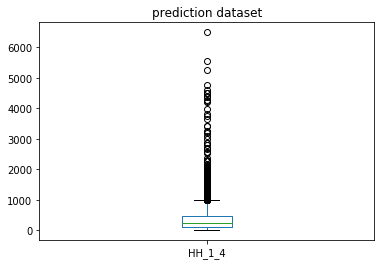

In [172]:
df_to_predict["HH_1_4"].plot( kind = "box", title = "prediction dataset")

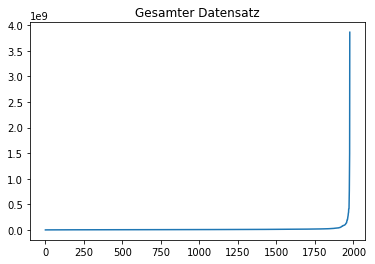

In [181]:
df_gemeinden.sort_values(by=["revenue_avg1"]).reset_index()["revenue_avg1"].plot(title= "Gesamter Datensatz")


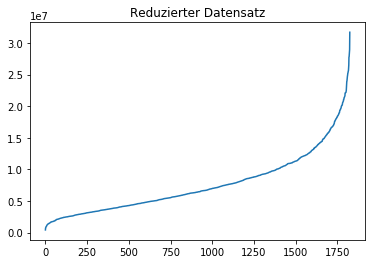

In [179]:
df_labeled.sort_values(by=["revenue_avg1"]).reset_index()["revenue_avg1"].plot(title= "Reduzierter Datensatz")


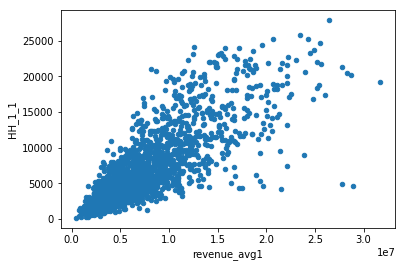

In [69]:
df_labeled.plot(kind = "scatter", x="revenue_avg1", y="HH_1_1")

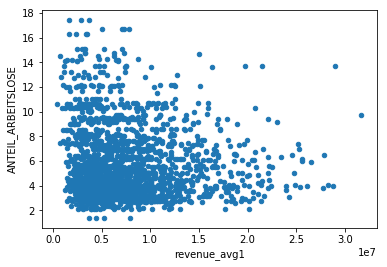

In [42]:
df_labeled.plot(kind = "scatter", x="revenue_avg1", y="ANTEIL_ARBEITSLOSE")

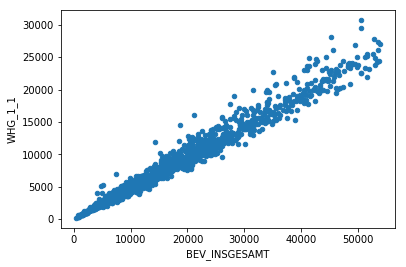

In [118]:
df_labeled.plot(kind = "scatter", x="BEV_INSGESAMT", y="WHG_1_1")

In [141]:
df_corr = df_extract.corr()["EINK_JE_EINW"]

df_corr.sort_values()

ANTEIL_ARBEITSLOSE              -0.74
RS_Land                         -0.45
AGS_12                          -0.44
RAU_RS                          -0.44
RS_ALT                          -0.44
AGS_12_filled                   -0.44
AGS_8                           -0.44
BESIEDLUNGSSCHLUESSEL           -0.34
ANTEIL_LANDWIRTSCHAFTSFLAECHE   -0.29
ANTEIL_LANGZEITARBEITSLOSE      -0.25
Shape__Area                     -0.16
Shape__Length                   -0.15
FLAECHE_QM                      -0.14
WHG_3_2                         -0.13
GEB_3_2                         -0.13
GEB_2_2                         -0.13
Shape_Leng                      -0.12
LENGTH                          -0.12
RS_VB                           -0.12
RS_Gem                          -0.11
WHG_3_3                         -0.10
GEB_3_3                         -0.10
GEB_2_3                         -0.10
WHG_6_5                         -0.06
RS_Kreis                        -0.05
REL_1_4                         -0.04
WHG_7_3     

In [212]:
bev_corr = df_extract.corr()["BEV_INSGESAMT"]

bev_highest_corr_feat = bev_corr[bev_corr.between(0.9, 1)]

bev_highest_corr_feat_set = set(bev_highest_corr_feat.index)

#reduced_feat_set = set(df_extract.columns) - bev_highest_corr_feat_set

In [213]:
s = set(bev_highest_corr_feat.index)
ss = set(df_extract.columns.values)

In [214]:
new_feat_set = ss.difference(s)

In [216]:
new_feat_set + "BEV_INSGESAMT"

TypeError: unsupported operand type(s) for +: 'set' and 'str'

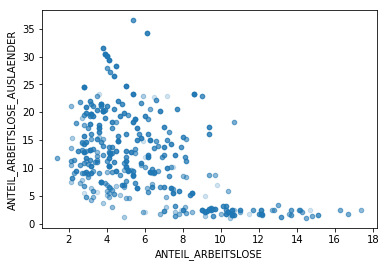

In [207]:
df_labeled.plot(kind = "scatter", x="ANTEIL_ARBEITSLOSE", y="ANTEIL_ARBEITSLOSE_AUSLAENDER", alpha=0.2)

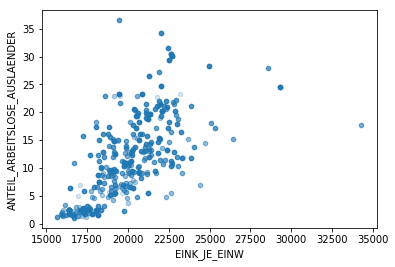

In [147]:
df_labeled.plot(kind = "scatter", y="ANTEIL_ARBEITSLOSE_AUSLAENDER", x="EINK_JE_EINW", alpha=0.2)

,BEV_INSGESAMT,osm_nodes_counter,ANTEIL_SIEDLUNG_VERKEHR,BEV_JE_QM,HH_1_4,ANTEIL_ARBEITSLOSE,EINK_JE_EINW,revenue_avg1
BEV_INSGESAMT,1.00,0.76,0.43,0.54,0.99,-0.04,0.13,0.78
osm_nodes_counter,0.76,1.00,0.29,0.39,0.75,-0.05,0.13,0.85
ANTEIL_SIEDLUNG_VERKEHR,0.43,0.29,1.00,0.51,0.45,-0.28,0.45,0.36
BEV_JE_QM,0.54,0.39,0.51,1.00,0.52,-0.16,0.31,0.52
HH_1_4,0.99,0.75,0.45,0.52,1.00,-0.08,0.16,0.75
ANTEIL_ARBEITSLOSE,-0.04,-0.05,-0.28,-0.16,-0.08,1.00,-0.74,-0.09
EINK_JE_EINW,0.13,0.13,0.45,0.31,0.16,-0.74,1.00,0.28
revenue_avg1,0.78,0.85,0.36,0.52,0.75,-0.09,0.28,1.00


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001F2453B9278>,
      dtype=object)

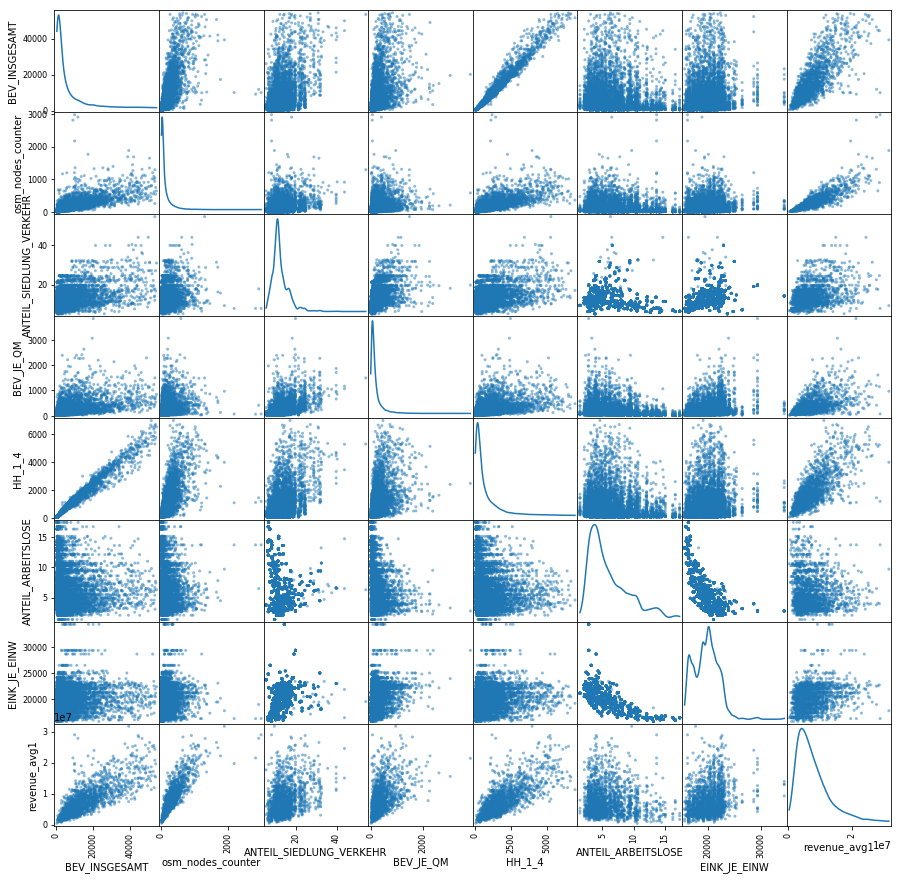

In [76]:
collist = ["BEV_INSGESAMT", "osm_nodes_counter", "ANTEIL_SIEDLUNG_VERKEHR", "BEV_JE_QM", "HH_1_4", 
           "ANTEIL_ARBEITSLOSE", "EINK_JE_EINW", "revenue_avg1"]



display(df_extract[collist].corr(method="pearson"))

pd.plotting.scatter_matrix(df_extract[collist], figsize=(15, 15), diagonal='kde')


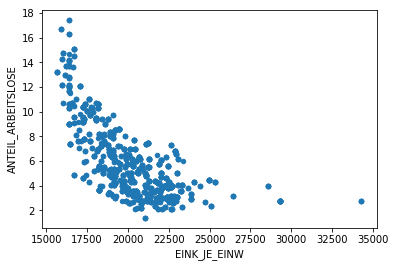

In [79]:
df_labeled.plot(kind = "scatter", x="EINK_JE_EINW", y="ANTEIL_ARBEITSLOSE")

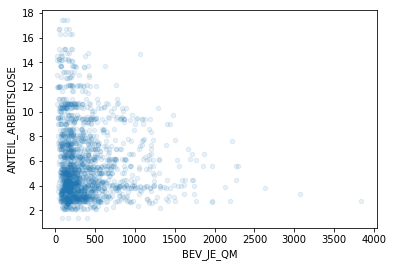

In [109]:
df_labeled.plot(kind = "scatter", x="BEV_JE_QM", y="ANTEIL_ARBEITSLOSE", alpha=0.1)

In [110]:
df_extract[["BEV_INSGESAMT", "ANTEIL_ARBEITSLOSE"]].corr()

,BEV_INSGESAMT,ANTEIL_ARBEITSLOSE
BEV_INSGESAMT,1.00,-0.04
ANTEIL_ARBEITSLOSE,-0.04,1.00


array([nan, 'Emden, Kreisfreie Stadt',
       'Frankenthal (Pfalz), Kreisfreie Stadt',
       'Neustadt an der Weinstraße, Kreisfreie Stadt',
       'Speyer, Kreisfreie Stadt', 'Zweibrücken, Kreisfreie Stadt',
       'Passau', 'Memmingen', 'Kreisfreie Stadt Wismar, Hansestadt',
       'Suhl, krsfr. Stadt', 'Eisenach, krsfr. Stadt'], dtype=object)

In [6]:
%%latex
\begin{align}
x_{norm} = \frac{x_{akt} - x_{min}}{x_{max}−x_{min}} ~mit~i \in (1,..., n),~n = Anzahl~Stichproben
\end{align}

<IPython.core.display.Latex object>